### Jakub Ochman    grupa 3.   AiR
#### Zadanie 1
Implementacja Algorytmu A* :

In [1]:
import numpy as np
import math

def path(sp, u, s, p, Tz, price): # parametry -> sp - lista poprzedników, u - wierzchołek, s - wierzchołek początkowy
    # p - słownik - poprzedni wierzchołek: następny wierzchołek, Tz - zbiór wierzchołków odwiedzonychm, prize - koszt
    if u not in sp:  # jak wierzchołek nie należy do sp, to jest ostatni, trzeba dodać.
        sp.append(u) 
    if u not in p: # jak wierzchołek nie ma rodzica, to najwyraźniej s = k
        return sp
    if p[u] in Tz: # jak poprzednik wierzchołka jest w Tz to trzeba go dodać do listy sp
        sp.append(p[u])
    if p[u] != s: # jak poprzednik nie jest wierzchołkiem startowym to rekurencyjnie wywołuje się funkcje
        path(sp, p[u], s, p, Tz, price) # parametry te same, poza wierzchołkiem, podaje się jego poprzednika
    # w ten sposób rekurencyjnie tworzy się listę od docelowego wierzchołka do startowego
    return list(reversed(sp)), price # zwraca krotkę (lista, koszt)
    

def A_star(s, k, G, G_weights, G_estimation):
    Tz = [] # zbiór wierzchołków odwiedzonych
    To = [s] # zbiór wierzchołków nieodwiedzonych
    g = {}  # aktualny koszt osiagnięcia wierzchołka z wierzchołka s
    f = {} # funkcja kosztu  g + h
    p = {} # zbiór przechowujący wierzchołek -> poprzednik
    g[s] = 0 # koszt dla wierzchołka s to 0
    sp = [] # najkrótsza droga od s do k

    for u in G:   # Pętla wpisująca inf dla każdego wierzchołka w f
        f[u] = np.inf   # Rzeczywista wartość zostanie policzona później
    f[s] = 0   # element startowy znajduje się u celu, więc f = 0

    while To:   # dopóki nie sprawdzono wszystkich wierzchołków
        min = np.inf    # wyszukiwanie arg_min, w tym celu potrzeba minimalnej (na start maksymalnej) wartości
        arg_min = None   # zwracany element
        for u in To:   # wyszukiwanie arg_min wśród u w To
            if f[u] < min:  # jak f ma mniejsze to trzeba się na niego przenieść
                min = f[u]  # ustawianie min na f (u)
                arg_min = u # jest minimalny (na razie)
        if arg_min == None: # Sprawdzenie czy arg_min == None, na wszelki wypadek, powinien być niespójny
            break
        x = arg_min  # od teraz arg_min staje się x
        if x == k:  # jeśli to szukany, to kończymy działanie
            return path(sp, k, s, p, Tz, g[k])   # funkcja wyznaczająca ścieżkę na podstawie poprzedników
        To.remove(x)  # usuwanie x z To
        Tz.append(x)  # dodawanie x do Tz
        for y in G[x]:   # Dla każdego sąsiada x
            if y in Tz:  # Jak już był sprawdzany to jest pomijany
                continue
            g_star = g[x] + G_weights(x, y)  # nowa wartość kosztu
            improv = False  
            if y not in To:  # Jeśli y nie jest w głównej kolejce do zbadania
                To.append(y)   # to trzeba go tam dodać
                improv = True  # i zaznaczyć, że znaleziono lepszą ścieżkę
            elif g_star < g[y]:  # jeśli już był sprawdzany, to trzeba sprawdzić czy aktualna ścieżka 
                improv = True   # ma mniejszą wagę, jak tak, to ta jest lepsza niż poprzednia
            if improv:   # jak y nie był sprawdzany, albo znaleziono lepszą ścieżke
                p[y] = x  # dodawanie x jako poprzednika y
                g[y] = g_star  # ustawienie kosztu y jako tego wyliczonego
                f[y] = g[y] + G_estimation(y, k) # nowa wartość całościowej funkcji kosztu
    # W tym miejscu funkcja znajduje się dla niespójnego grafu
    return None
            

Poniżej znajduje się funkcja realizująca wyświetlenie grafu w formie graficznej. Do funkcji z pierwszego laboratorium dodano obsługę i wyświetlenie wag krawędzi oraz możliwość dodania listy wierzchołków, które utworzą graf zaznaczony na czerwono. W ten sposób w kolejnych przykładach zrealizowane będzie wyświetlenie najkrótszej drogi między wierzchołkami grafu na rysunek tego grafu.

In [2]:

import networkx as nx
import matplotlib.pyplot as plt

def print_graph(graph, pos=None, weights=None, path=None):
    G = nx.Graph()
    
    for key, items in graph.items():
        for item in items:
            G.add_edge(key, item)
    
    plt.figure(figsize=(7, 7))
    
    if pos is None:
        pos = nx.spring_layout(G)
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=14)
    
    if weights:
        edge_labels = {(u, v): weights.get((u, v), weights.get((v, u), "")) for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='blue')
    
    if path and len(path) > 1:
        path_edges = list(zip(path, path[1:]))
        G_path = nx.Graph()
        G_path.add_edges_from(path_edges)
        nx.draw(G_path, pos, with_labels=True, node_color='red', edge_color='red', node_size=500, font_size=14, width=2)
    
    plt.show()

W celu łatwego definiowania grafów zdecydowano się na reprezentację w formie listy sąsiedztwa. W podobny sposób zapisano pozycje każdego wierzchołka. Wagi zostały wyznaczone w funkcji poprzez policzenie odległości między wierzchołkami, następnie wynik został zaokrąglony w górę. Do uzyskanej odległości dodano liczbę losową dla każdego wierzchołka zawierającą się w przedziale 2, 5. Dzięki temu funkcja heurystyczna na pewno jest mniejsza niż funkcja wagowa. Optymalnie funkcja heurystyczna powinna być równa funkcji wagowej, im mniejsza od funkcji wagowej, tym mniej dokładna estymacja ścieżki. Najważniejsze, żeby heurystyka nie była większa, bo wtedy algorytm znacząco ucierpi na wydajności.

In [3]:
import random

graph = {    

0: [1, 9, 7],
1: [0, 2, 8, 7, 6, 3],
2: [1, 3, 5],
3: [2, 4, 9, 1],
4: [3, 5, 9, 8, 7],
5: [4, 6, 9, 2],
6: [5, 1],
7: [1, 8, 0, 4],
8: [7, 9, 1, 4],
9: [8, 0, 4, 5, 3]

}

graph_pos = {
    0: (0, 2),
    1: (4, 3),
    2: (9, 8),
    3: (3, 5),
    4: (0, 4),
    5: (3, 7),
    6: (6, 6),
    7: (5, 2),
    8: (0, 2),
    9: (9, 3)
}
def calculate_edge_weights(adjacency_list, coordinates):
    edge_weights = {}
    
    for vertex1, neighbors in adjacency_list.items():
        x1, y1 = coordinates[vertex1]
        
        for vertex2 in neighbors:
            if (vertex2, vertex1) in edge_weights:
                continue 
            x2, y2 = coordinates[vertex2]
            
            distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            weight = math.ceil(distance) + random.randint(2, 5)
            
            edge_weights[(vertex1, vertex2)] = weight
    
    return edge_weights

graph_weights = calculate_edge_weights(graph, graph_pos)

Funkcje pomocnicze zdefiniowane w celu usprawnienia przekaywanych danych do funkcji A_star. Funkcja distance reprezentuje estymację heurystyczną odległości między wierzchołkami. Natomiast funkcja g_weights zwraca wagę krawędzi między dwoma wierzchołkami. Zastosowanie pomocnicznych funkcji w obrębie głównych funkcji wpływa na uniwersalność kodu. Dzięki temu wagi i odległości między punktami mogą być zapisane w dowolny sposób, następnie wyliczone w obrębie funkcji pomocniczej i zastosowane w głównej funkcji.

In [4]:
def distance(u, v):
    x1, y1 = graph_pos[u]
    x2, y2 = graph_pos[v]
    d = math.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))
    return d

def g_weights(u, v):
    if (u, v) in graph_weights:
        return graph_weights[(u, v)]
    elif (v, u) in graph_weights:
        return graph_weights[(v, u)]
    return np.inf


Przykład działania algorytmu dla grafu cyklicznego o 10 wierzchołkach i około 20 krawędziach:

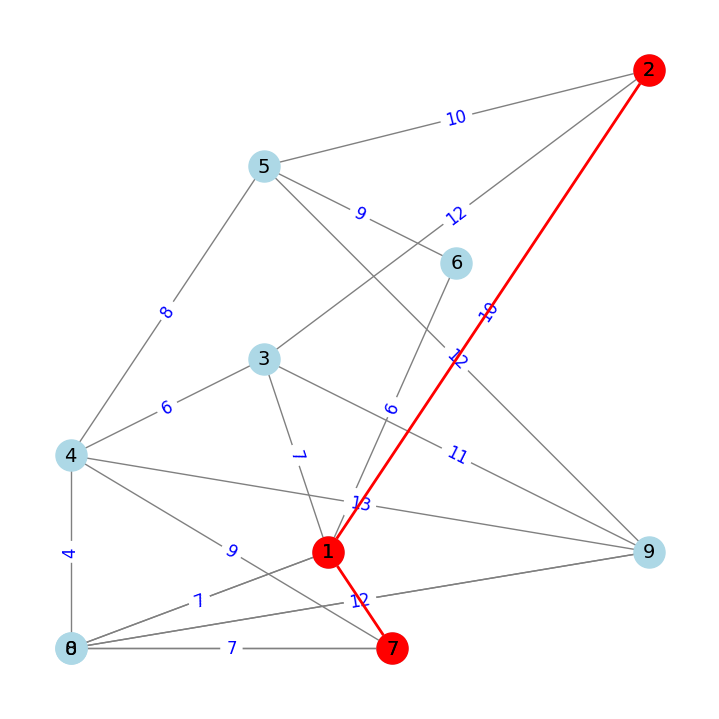

Kolejność odwiedzania wierzchołków: [2, 1, 7]
Całkowity koszt: 16


In [5]:
graph2, price = A_star(2, 7, graph, g_weights, distance)
print_graph(graph, graph_pos, graph_weights, graph2)
print("Kolejność odwiedzania wierzchołków:", graph2)
print("Całkowity koszt:", price)

#### Zadanie 2


##### Wagi krawędzi i funkcja heurystyczna
Algorytm A* wymaga, aby koszty krawędzi były nieujemne, ponieważ w przeciwnym razie mógłby błędnie ocenić najkrótszą ścieżkę. Jeśli wszystkie krawędzie mają podobne koszty, działa on podobnie do algorytmu BFS, ale przy dużych różnicach w wagach kluczowa staje się dobra heurystyka. Efektywność A* zależy od jakości heurystyki, im lepiej szacuje rzeczywisty koszt dojścia do celu, tym szybciej algorytm znajduje optymalne rozwiązanie. Dodatkowo, jeśli heurystyka spełnia pewne warunki spójności, A* nie musi ponownie odwiedzać już sprawdzonych węzłów, co przyspiesza działanie.

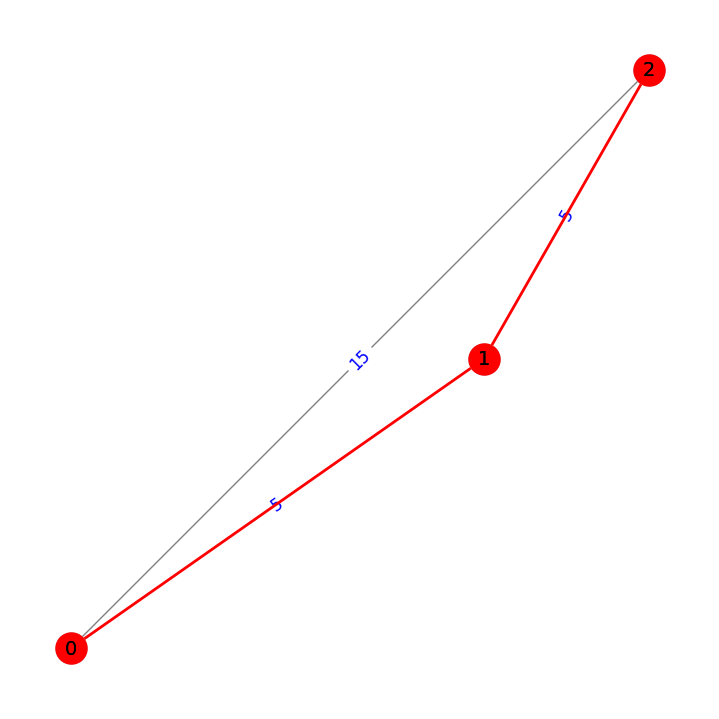

Kolejność odwiedzania wierzchołków: [0, 1, 2]
Całkowity koszt: 10


In [6]:

graph = {    
    0: [1, 2],
    1: [0, 2],
    2: [0, 1]
}

graph_pos = {
    0: (0, 0),
    1: (5, 1),
    2: (7, 2)
}

graph_weights = {
    (0, 1): 5,
    (1, 2): 5,
    (0, 2): 15
}

graph2, price = A_star(0, 2, graph, g_weights, distance)
print_graph(graph, graph_pos, graph_weights, graph2)
print("Kolejność odwiedzania wierzchołków:", graph2)
print("Całkowity koszt:", price)

Przykład dla grafu z ujemnymi wagami krawędzi.
Według wikipedii algorytm nie działa poprawnie w grafie z ujemnymi krawędziami. Ujemne krawędzie mogą zaburzać działanie algorytmu poprzez problemy z heurystyką. Algorytm może wpadać w nieskończone pętle. Takiej sytuacji nie udało się zaobserwować na poniższym grafie. Mimo zastosowania różnych kombinacji krawędzi i cykli o ujemnych wagach, algorytm nadal działa (teoretycznie) poprawnie, wybierając trasę o najmniejszej (ujemnej) wadze. Heurystyka w tym przypadku jest pomijana.

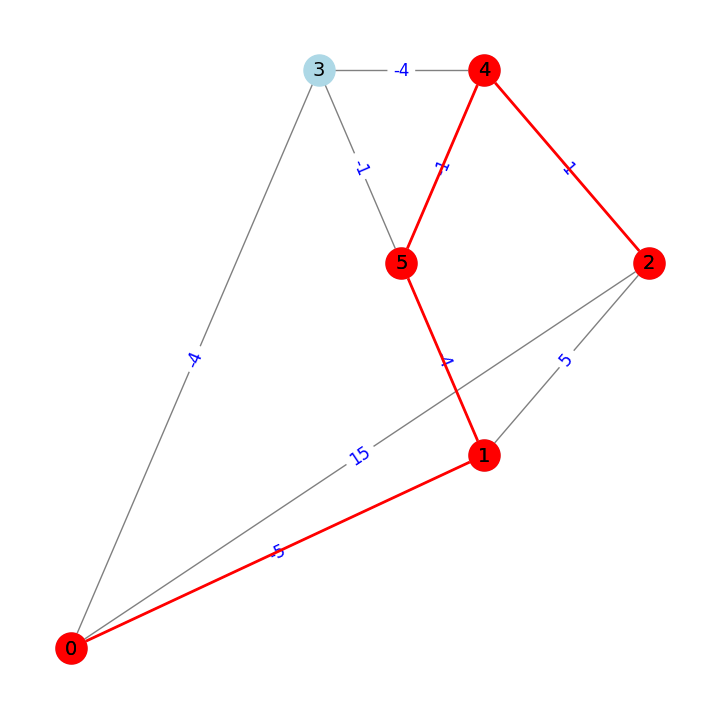

Kolejność odwiedzania wierzchołków: [0, 1, 5, 4, 2]
Całkowity koszt: -11


In [7]:
graph = {    
    0: [1, 2, 3],
    1: [0, 2, 5],
    2: [0, 1, 4],
    3: [0, 4, 5],
    4: [2, 3, 5],
    5: [1, 3, 4]
}

graph_pos = {
    0: (0, 0),
    1: (5, 1),
    2: (7, 2),
    3: (3, 3),
    4: (5, 3),
    5: (4, 2)
}

graph_weights = {
    (0, 1): -5,
    (1, 2): 5,
    (0, 2): 15,
    (0, 3): -4,
    (3, 5): -1,
    (4, 5): -1,
    (4, 2): -1,
    (3, 4): -4,
    (1, 5): -4
}

graph2, price = A_star(0, 2, graph, g_weights, distance)
print_graph(graph, graph_pos, graph_weights, graph2)
print("Kolejność odwiedzania wierzchołków:", graph2)
print("Całkowity koszt:", price)

##### Rzadkość i rozmiar grafu
W rzadkich grafach algorytm zwykle działa szybciej, analogicznie z mniejszymi grafami. W przypadku dużych grafów z dużą ilością połączeń algorytm nadal spełnia swoje zadanie optymalnie, jednak czas obliczenia optymalnej drogi rośnie. Jako przykład podano graf złożony z 100 wierzchołków połączonych w siatkę. Algorytm uruchomiony na tym grafie przetwarza się około 0.6s, dla porównania dla grafu o 10 wierzchołkach trwało to krócej niż 0.1s

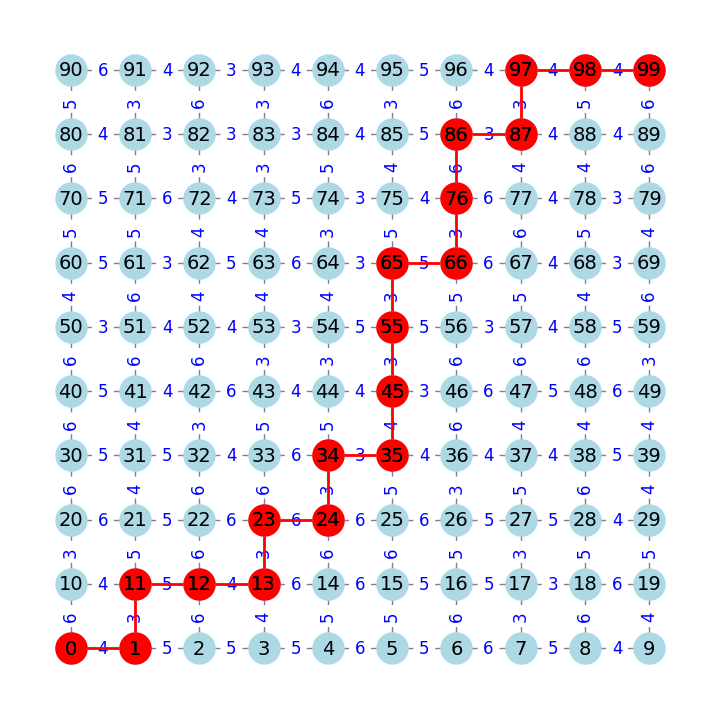

Kolejność odwiedzania wierzchołków: [0, 1, 11, 12, 13, 23, 24, 34, 35, 45, 55, 65, 66, 76, 86, 87, 97, 98, 99]
Całkowity koszt: 69


In [8]:
graph = {}
graph_pos = {}

size = 10  # Rozmiar siatki (10x10)

for y in range(size):
    for x in range(size):
        node = y * size + x  # Numer wierzchołka
        graph_pos[node] = (x, y)  # Przypisanie pozycji
        
        neighbors = []
        if x > 0:
            neighbors.append(node - 1)  # Sąsiad z lewej
        if x < size - 1:
            neighbors.append(node + 1)  # Sąsiad z prawej
        if y > 0:
            neighbors.append(node - size)  # Sąsiad z góry
        if y < size - 1:
            neighbors.append(node + size)  # Sąsiad z dołu
        
        graph[node] = neighbors  # Przypisanie sąsiedztwa

graph_weights = calculate_edge_weights(graph, graph_pos)

graph2, price = A_star(0, 99, graph, g_weights, distance)
print_graph(graph, graph_pos, graph_weights, graph2)
print("Kolejność odwiedzania wierzchołków:", graph2)
print("Całkowity koszt:", price)

##### Spójność Grafu
Oczywistym jest, że jak nie ma połączenia między wierzchołkami to algorytm nie znajdzie optymalnej trasy między nimi. W przypadku algorytmu przedstawionego w pseudokodzie na wykładzie. Sytuacja taka ma miejsce gdy wszystkie elementy zostają usunięte z To, a nie osiągnięto zamierzonego wierzchołka. W takim wypadku algorytm zwraca None. W poniższym przykładzie zaprezentowano graf niespójny, algorytm zwrócił dla niego wartość None. Warto zaznaczyć jednak, że zależy to od wyboru wierzchołków. Jeśli wybrane zostaną wierzchołki w obrębie tego samego podgrafu, to algorytm znajdzie ścieżkę między nimi.

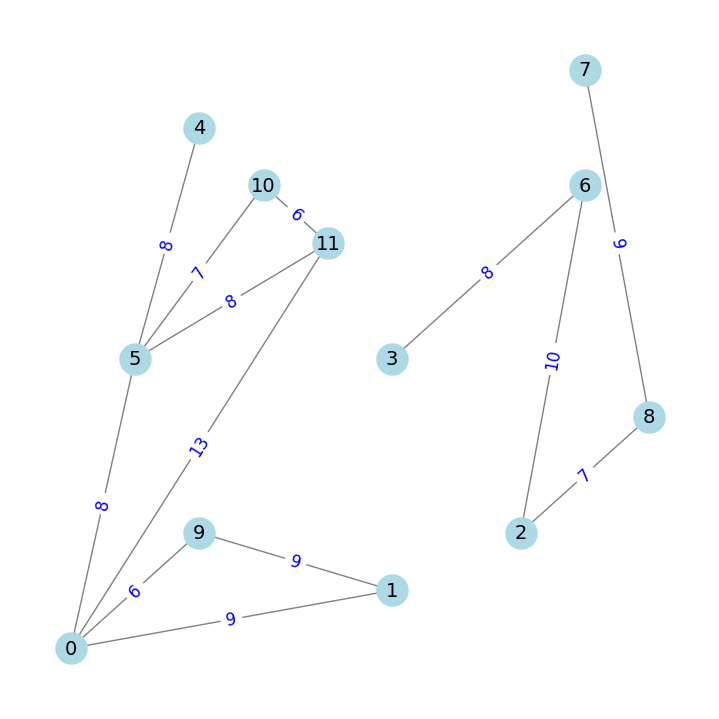

Graf niespójny, brak ścieżki między wierzchołkami


In [9]:
graph = {    
    0: [1, 5, 9, 11],
    1: [0, 9],
    2: [6, 8],
    3: [6],
    4: [5],
    5: [0, 4, 10, 11],
    6: [2, 3],
    7: [8],
    8: [2, 7],
    9: [0, 1],
    10: [5, 11],
    11: [0, 5, 10]
}

graph_pos = {
    0: (0, 0),
    1: (5, 1),
    2: (7, 2),
    3: (5, 5),
    4: (2, 9),
    5: (1, 5),
    6: (8, 8),
    7: (8, 10),
    8: (9, 4),
    9: (2, 2),
    10: (3, 8),
    11: (4, 7)
}

graph_weights = calculate_edge_weights(graph, graph_pos)

print_graph(graph, graph_pos, graph_weights)

graph2 = A_star(10, 3, graph, g_weights, distance)
if graph2 == None:
    print("Graf niespójny, brak ścieżki między wierzchołkami")
else:
    print_graph(graph, graph_pos, graph_weights, graph2[0])
    print("Kolejność odwiedzania wierzchołków:", graph2[0])
    print("Całkowity koszt:", price[1])

Poniżej przykład grafu niespójnego, ale poszukiwania ścieżki w obrębie jednego podgrafu.

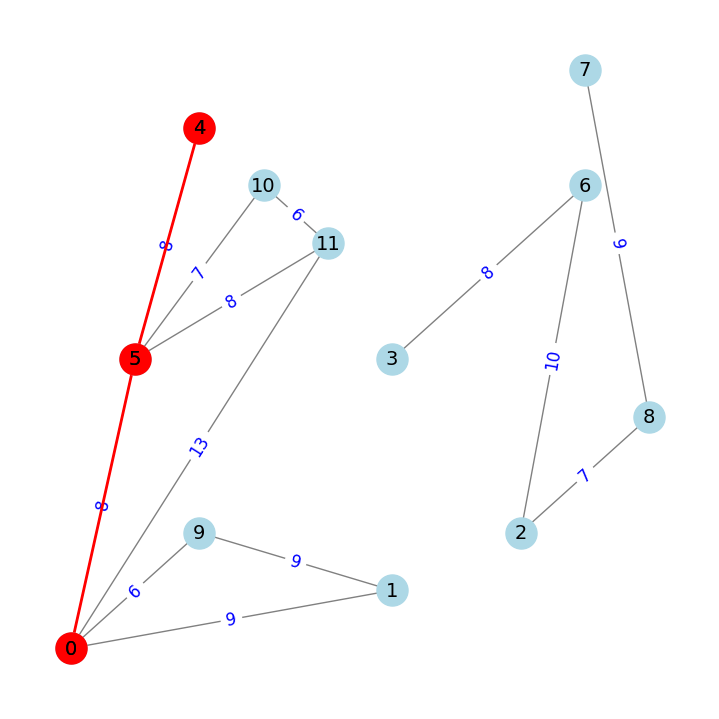

Kolejność odwiedzania wierzchołków: [0, 5, 4]
Całkowity koszt: 16


In [10]:
graph2 = A_star(0, 4, graph, g_weights, distance)
if graph2 == None:
    print("Graf niespójny, brak ścieżki między wierzchołkami")
else:
    print_graph(graph, graph_pos, graph_weights, graph2[0])
    print("Kolejność odwiedzania wierzchołków:", graph2[0])
    print("Całkowity koszt:", graph2[1])

#### Zadanie 3
Złożoność czasowa algorytmu A* zależy od jakości zastosowanej funkcji heurystycznej.

Złożoność optymistyczna: O(d) - jeśli heurystyka idealnie przewiduje koszt, algorytm wybiera najlepszą ścieżkę bez zbędnego eksplorowania innych węzłów.
Złożoność pesymistyczna: O(b^d) gdy heurystyka jest źle dobrana, algorytm może działać podobnie do przeszukiwania wszerz (BFS), odwiedzając prawie wszystkie możliwe ścieżki.

Im bardziej precyzyjna jest heurystyka, tym mniej węzłów musi zostać przeanalizowanych, co przekłada się na mniejszą złożoność obliczeniową. Efektywność heurystyki można określić poprzez efektywny współczynnik rozgałęzienia, który oznacza średnią liczbę węzłów faktycznie odwiedzanych podczas działania 
algorytmu.

Złożoność pamięciowa algorytmu zawsze wynosi O(b^d) ponieważ musi on przechowywać w pamięci wszystkie odwiedzone węzły oraz kolejkę priorytetową. W dużych grafach może to prowadzić do znacznego zużycia pamięci, co stanowi jedną z głównych wad tego algorytmu. Z tego powodu stosuje się warianty algorytmu, ograniczające zużycie pamięci.


#### Źródła:
- Na podstawie materiałów z zajęć oraz wykładu
- Na podstawie https://www.baeldung.com/cs/a-star-algorithm
- Na podstawie https://www.geeksforgeeks.org/a-search-algorithm/
- Na podstawie opisu algorytmu https://en.wikipedia.org/wiki/A*_search_algorithm
#### Środowisko:
Jupiter Notebook w Visual Studio Code z rozszerzeniem Jupiter, Python

